###IMPORT LIBRARY DAN SETUP AWAL

In [ ]:
### ==========================================================
### 1. IMPORT LIBRARY DAN SETUP AWAL
### ==========================================================

# Library standar
import os
import re
import warnings
from datetime import datetime

# Library untuk data dan analisis
import pandas as pd
import numpy as np

# Library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Library machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
!pip install catboost
from catboost import CatBoostRegressor
from statsmodels.tsa.arima.model import ARIMA  # ARIMA ditambahkan
force_row_wise=True

# Pengaturan tampilan dan peringatan
warnings.filterwarnings('ignore')
sns.set_palette("viridis")
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["figure.figsize"] = (10, 6)

print("✅ Library berhasil diimpor dan konfigurasi visualisasi siap digunakan.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00
✅ Library berhasil diimpor dan konfigurasi visualisasi siap digunakan.


###LOAD DATASET DAN VALIDASI FILE

In [ ]:
### ==========================================================
### 2. LOAD DATASET DAN VALIDASI FILE
### ==========================================================

def load_csv(filename, optional=False):
    if os.path.exists(filename):
        try:
            df = pd.read_csv(filename)
            print(f"✅ {filename} berhasil dimuat | shape = {df.shape}")
            return df
        except Exception as e:
            print(f"⚠️  Gagal memuat {filename}: {e}")
            return None
    else:
        if optional:
            print(f"⚠️  File opsional tidak ditemukan: {filename}")
            return None
        else:
            raise FileNotFoundError(f"❌ File wajib tidak ditemukan: {filename}")

# Memuat dataset utama
hotel_data = load_csv('hotels_data.csv')
hotel_bookings = load_csv('hotels_price.csv')

# Memuat dataset tambahan (opsional)
hotel_reviews = load_csv('hotels_reviews.csv', optional=True)
nearby_places = load_csv('nearby_places.csv', optional=True)
weather_data = load_csv('weather.csv', optional=True)  # Tambahan variabel cuaca

# Menampilkan ringkasan data yang berhasil dimuat
print("\n=== INFORMASI DATASET ===")
if hotel_data is not None:
    print(f"Hotel Data: {hotel_data.shape}")
if hotel_bookings is not None:
    print(f"Hotel Bookings: {hotel_bookings.shape}")
if hotel_reviews is not None:
    print(f"Hotel Reviews: {hotel_reviews.shape}")
if nearby_places is not None:
    print(f"Nearby Places: {nearby_places.shape}")
if weather_data is not None:
    print(f"Weather Data: {weather_data.shape}")

print("\n✅ Semua dataset utama berhasil dimuat.")


✅ hotels_data.csv berhasil dimuat | shape = (60, 13)
✅ hotels_price.csv berhasil dimuat | shape = (11040, 16)
✅ hotels_reviews.csv berhasil dimuat | shape = (8, 2002)
✅ nearby_places.csv berhasil dimuat | shape = (3531, 7)
✅ weather.csv berhasil dimuat | shape = (184, 6)

=== INFORMASI DATASET ===
Hotel Data: (60, 13)
Hotel Bookings: (11040, 16)
Hotel Reviews: (8, 2002)
Nearby Places: (3531, 7)
Weather Data: (184, 6)

✅ Semua dataset utama berhasil dimuat.


###Data Cleaning dan Eksplorasi Awal

In [ ]:
### ==========================================================
### 3. DATA CLEANING DAN EKSPLORASI AWAL
### ==========================================================

# ==========================================================
# DATASET: hotel_bookings
# ==========================================================
print("\n=== DATASET HOTEL BOOKINGS ===")
display(hotel_bookings.head())
print("\nKolom dataset bookings:", hotel_bookings.columns.tolist())
hotel_bookings.info()
print("\nNilai kosong per kolom:")
print(hotel_bookings.isnull().sum())

# Bersihkan harga
def clean_price(price_str):
    if isinstance(price_str, str):
        s = price_str.replace(',', '.')
        s = re.sub(r'[^\d.]', '', s)
        try:
            return float(s)
        except ValueError:
            return np.nan
    return price_str

hotel_bookings['Price_numeric'] = hotel_bookings['Price'].apply(clean_price)

missing_prices = hotel_bookings['Price_numeric'].isna().sum()
print(f"\nJumlah baris dengan harga tidak valid: {missing_prices}")

if missing_prices < 0.1 * len(hotel_bookings):
    hotel_bookings = hotel_bookings.dropna(subset=['Price_numeric'])
else:
    print("Perlu cek ulang format harga.")

# Konversi tanggal
hotel_bookings['Date'] = pd.to_datetime(hotel_bookings['Date'], errors='coerce')
hotel_bookings['booking_month'] = hotel_bookings['Date'].dt.month
hotel_bookings['booking_day'] = hotel_bookings['Date'].dt.day
hotel_bookings['booking_dayofweek'] = hotel_bookings['Date'].dt.dayofweek

# Kolom final
hotel_bookings = hotel_bookings[['Name', 'Hotel_id', 'Date', 'Price_numeric',
                                 'booking_month', 'booking_day', 'booking_dayofweek']]

print("\nStruktur akhir hotel_bookings:")
print(hotel_bookings.columns.tolist())
display(hotel_bookings.head())

# ==========================================================
# DATASET: hotel_data
# ==========================================================
print("\n=== DATASET HOTEL DATA ===")
display(hotel_data.head())

# Bersihkan rating dan review count
hotel_data['rating_numeric'] = hotel_data['rating'].apply(
    lambda x: float(str(x).replace(',', '.')) if pd.notnull(x) else np.nan
)

def clean_review_count(x):
    if pd.isnull(x):
        return np.nan
    s = str(x).lower().replace(',', '.')
    s = re.sub(r'[^\d.]', '', s)
    try:
        val = float(s)
        if 'rb' in str(x).lower():
            val *= 1000
        return val
    except:
        return np.nan

hotel_data['reviews_count_numeric'] = hotel_data['reviews_count'].apply(clean_review_count)

# Hitung jumlah fasilitas
def extract_amenities(text):
    if isinstance(text, str):
        text = text.replace(':', ';').replace(',', ';')
        items = [i.strip() for i in text.split(';') if i.strip()]
        return items
    return []

hotel_data['amenities_list'] = hotel_data['amenities'].apply(extract_amenities)
hotel_data['amenities_count'] = hotel_data['amenities_list'].apply(len)
hotel_data.loc[hotel_data['amenities_count'] > 80, 'amenities_count'] = 80

# Hapus duplikat hotel
if hotel_data['hotel_id'].duplicated().sum() > 0:
    hotel_data = hotel_data.drop_duplicates(subset='hotel_id', keep='first')

# Ekstraksi koordinat
def extract_coordinates(coord_text):
    if isinstance(coord_text, str):
        lat_match = re.search(r'Lat:\s*([-+]?[0-9]*\.?[0-9]+)', coord_text)
        lng_match = re.search(r'Lng:\s*([-+]?[0-9]*\.?[0-9]+)', coord_text)
        if lat_match and lng_match:
            return (float(lat_match.group(1)), float(lng_match.group(1)))
    return (np.nan, np.nan)

hotel_data[['latitude', 'longitude']] = pd.DataFrame(
    hotel_data['coordinates'].apply(extract_coordinates).tolist(),
    index=hotel_data.index
)

hotel_data = hotel_data[['hotel_id', 'name', 'rating_numeric',
                         'reviews_count_numeric', 'amenities_count',
                         'category', 'location', 'latitude', 'longitude']]

print("\nData hotel_data setelah pembersihan:")
display(hotel_data.head())

# ==========================================================
# DATASET: weather_data
# ==========================================================
if weather_data is not None:
    print("\n=== DATASET WEATHER DATA ===")
    display(weather_data.head())
    print("\nKolom weather_data:", weather_data.columns.tolist())
    weather_data.info()
    print("\nNilai kosong per kolom:")
    print(weather_data.isnull().sum())

    # Konversi kolom tanggal
    if 'date' in weather_data.columns:
        weather_data['date'] = pd.to_datetime(weather_data['date'], errors='coerce')

    # Kolom final (disederhanakan, kategori tetap dipakai nanti)
    weather_data = weather_data[['date', 'temperature_c', 'humidity_pct', 'rain_mm', 'weather_encoded']]

    print("\nData weather_data setelah pembersihan:")
    display(weather_data.head())

# ==========================================================
# HASIL AKHIR SEMUA DATASET
# ==========================================================
print("\n=== RINGKASAN DATASET SETELAH PEMBERSIHAN ===")
print(f"Bookings: {len(hotel_bookings)} baris")
print(f"Hotel Data: {len(hotel_data)} baris")
if weather_data is not None:
    print(f"Weather Data: {len(weather_data)} baris")
print("\nKolom utama bookings:", hotel_bookings.columns.tolist())
print("Kolom utama hotel:", hotel_data.columns.tolist())
if weather_data is not None:
    print("Kolom utama cuaca:", weather_data.columns.tolist())
print("\nData sudah bersih dan siap untuk tahap penggabungan berikutnya.")



=== DATASET HOTEL BOOKINGS ===


,Name,Price,Hotel_id,Option_1_platform,Option_1_price,Option_2_platform,Option_2_price,Option_3_platform,Option_3_price,Option_4_platform,Option_4_price,Option_5_platform,Option_5_price,Option_6_platform,Option_6_price,Date
0,Hotel 88 Bandung Kopo,Rp336.648,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,trivago.co.id,Rp336.648,tiket.com,"Rp312,612",Hotel 88 Bandung Kopo,"Rp336,648",Bluepillow.com,"Rp372,256",Trip.com,Rp351.000,Wego Marketplace,Rp336.648,2025-05-01
1,Hotel 88 Bandung Kopo,Rp312.612,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,trivago.co.id,Rp312.612,tiket.com,"Rp336,648",Hotel 88 Bandung Kopo,"Rp390,000",Bluepillow.com,"Rp372,256",Trip.com,Rp351.000,Wego Marketplace,Rp312.612,2025-05-02
2,Hotel 88 Bandung Kopo,Rp393.911,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,trivago.co.id,Rp393.911,tiket.com,"Rp393,911",Hotel 88 Bandung Kopo,"Rp422,968",Bluepillow.com,"Rp392,852",Trip.com,Rp441.000,Wego Marketplace,Rp393.911,2025-05-03
3,Hotel 88 Bandung Kopo,Rp312.645,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,trivago.co.id,Rp312.645,tiket.com,"Rp336,648",Hotel 88 Bandung Kopo,"Rp390,000",Bluepillow.com,"Rp312,105",Trip.com,Rp351.000,Wego Marketplace,Rp312.645,2025-05-04
4,Hotel 88 Bandung Kopo,Rp312.645,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,trivago.co.id,Rp312.645,tiket.com,"Rp336,648",Hotel 88 Bandung Kopo,"Rp390,000",Bluepillow.com,"Rp312,105",Trip.com,Rp351.000,Wego Marketplace,Rp312.645,2025-05-05



Kolom dataset bookings: ['Name', 'Price', 'Hotel_id', 'Option_1_platform', 'Option_1_price', 'Option_2_platform', 'Option_2_price', 'Option_3_platform', 'Option_3_price', 'Option_4_platform', 'Option_4_price', 'Option_5_platform', 'Option_5_price', 'Option_6_platform', 'Option_6_price', 'Date']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11040 entries, 0 to 11039
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Name               11040 non-null  object
 1   Price              11040 non-null  object
 2   Hotel_id           11040 non-null  object
 3   Option_1_platform  11040 non-null  object
 4   Option_1_price     11040 non-null  object
 5   Option_2_platform  11040 non-null  object
 6   Option_2_price     11040 non-null  object
 7   Option_3_platform  11040 non-null  object
 8   Option_3_price     11040 non-null  object
 9   Option_4_platform  11040 non-null  object
 10  Option_4_price     11040 

,Name,Hotel_id,Date,Price_numeric,booking_month,booking_day,booking_dayofweek
0,Hotel 88 Bandung Kopo,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,2025-05-01,336.648,5,1,3
1,Hotel 88 Bandung Kopo,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,2025-05-02,312.612,5,2,4
2,Hotel 88 Bandung Kopo,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,2025-05-03,393.911,5,3,5
3,Hotel 88 Bandung Kopo,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,2025-05-04,312.645,5,4,6
4,Hotel 88 Bandung Kopo,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,2025-05-05,312.645,5,5,0



=== DATASET HOTEL DATA ===


,name,hotel_id,rating,reviews_count,location,contact,category,website,about,amenities,coordinates,thumbnails,link
0,Horison Ultima Hotel,ChIJR2XbVnzoaC4Rrcm3RoIWbQo,"4,2","10,3 rb","Jl. Pelajar Pejuang 45 No.121, Turangga, Kec. ...",(022)7305000,Hotel bintang 4,https://horisonultimabandung.com/,Hotel modern ini berjarak 2 km dari taman hibu...,"Kolam renang: Kolam renang luar, Kolam berenda...","Lat: -6.935329299999999, Lng: 107.6252088",http://lh5.googleusercontent.com/p/AF1QipN2Coi...,https://www.google.com/travel/search?q=Horison...
1,Bali World Hotel,ChIJd9tPhxzoaC4RxHBKCi82lDU,"4,2","3,6 rb","Jl. Soekarno-Hatta By Pass Timur No.713, Jatis...",(022)7332088,Hotel bintang 3,http://www.baliworldhotel.com/,"Hotel simpel ini berjarak 4,8 km dari taman hi...","Kolam renang: Kolam renang luar, Tak ada bak a...","Lat: -6.938430899999999, Lng: 107.6631013",http://lh3.googleusercontent.com/proxy/WrLdE5J...,https://www.google.com/travel/search?q=Bali%20...
2,West Point Hotel,ChIJZRnuuQvmaC4ReCG15Q1u2Ho,"4,3","4,3 rb","Jl. LMU.Nurtanio No.63, Dungus Cariang, Kec. A...",(022)20565858,Hotel bintang 4,https://www.westpointbandung.com/,Hotel kontemporer di jalan komersial dengan pe...,"Internet: Wi-Fi; Layanan: Resepsionis, Penatu ...","Lat: -6.9127049, Lng: 107.5780691",http://lh3.googleusercontent.com/p/AF1QipOrBh5...,https://www.google.com/travel/search?q=West%20...
3,de Braga by ARTOTEL,ChIJ6Rt6U0nnaC4RMgoC4IJ4WYg,"4,6","3,2 rb","Jl. Braga No.10, Braga, Kec. Sumur Bandung, Ko...",(022)86016100,Hotel bintang 4,https://artotelwanderlust.com/hotel/de-braga-b...,Hotel simpel ini berjarak 6 km dari Bandara In...,"Kolam renang: Kolam renang luar, Kolam berenda...","Lat: -6.920351399999999, Lng: 107.6100873",http://lh4.googleusercontent.com/proxy/xr4cT6n...,https://www.google.com/travel/search?q=de%20Br...
4,Hotel Savoy Homann Bandung,ChIJHREpHC_maC4RFhuMcU-xCU8,"4,6","9,9 rb","Jl. Asia Afrika No.112, Cikawao, Kec. Lengkong...",(022)4232244,Hotel bintang 4,https://savoyhomannbandung.com/,Hotel modern & mewah ini berjarak 4 menit berj...,"Kolam renang: Kolam renang di dalam ruangan, K...","Lat: -6.9218556, Lng: 107.6102631",http://lh5.googleusercontent.com/proxy/nO5-LOA...,https://www.google.com/travel/search?q=Hotel%2...



Data hotel_data setelah pembersihan:


,hotel_id,name,rating_numeric,reviews_count_numeric,amenities_count,category,location,latitude,longitude
0,ChIJR2XbVnzoaC4Rrcm3RoIWbQo,Horison Ultima Hotel,4.2,10300.0,31,Hotel bintang 4,"Jl. Pelajar Pejuang 45 No.121, Turangga, Kec. ...",-6.935329,107.625209
1,ChIJd9tPhxzoaC4RxHBKCi82lDU,Bali World Hotel,4.2,3600.0,24,Hotel bintang 3,"Jl. Soekarno-Hatta By Pass Timur No.713, Jatis...",-6.938431,107.663101
2,ChIJZRnuuQvmaC4ReCG15Q1u2Ho,West Point Hotel,4.3,4300.0,29,Hotel bintang 4,"Jl. LMU.Nurtanio No.63, Dungus Cariang, Kec. A...",-6.912705,107.578069
3,ChIJ6Rt6U0nnaC4RMgoC4IJ4WYg,de Braga by ARTOTEL,4.6,3200.0,32,Hotel bintang 4,"Jl. Braga No.10, Braga, Kec. Sumur Bandung, Ko...",-6.920351,107.610087
4,ChIJHREpHC_maC4RFhuMcU-xCU8,Hotel Savoy Homann Bandung,4.6,9900.0,80,Hotel bintang 4,"Jl. Asia Afrika No.112, Cikawao, Kec. Lengkong...",-6.921856,107.610263



=== DATASET WEATHER DATA ===


,date,temperature_c,rain_mm,humidity_pct,weather_condition,weather_encoded
0,2025-03-01,24.5,5.0,80,Cerah,0
1,2025-03-02,23.5,13.1,83,Hujan Ringan,2
2,2025-03-03,23.5,15.4,87,Hujan Ringan,2
3,2025-03-04,24.5,7.2,85,Hujan Ringan,2
4,2025-03-05,23.8,1.1,80,Cerah,0



Kolom weather_data: ['date', 'temperature_c', 'rain_mm', 'humidity_pct', 'weather_condition', 'weather_encoded']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               184 non-null    object 
 1   temperature_c      184 non-null    float64
 2   rain_mm            184 non-null    float64
 3   humidity_pct       184 non-null    int64  
 4   weather_condition  184 non-null    object 
 5   weather_encoded    184 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 8.8+ KB

Nilai kosong per kolom:
date                 0
temperature_c        0
rain_mm              0
humidity_pct         0
weather_condition    0
weather_encoded      0
dtype: int64

Data weather_data setelah pembersihan:


,date,temperature_c,humidity_pct,rain_mm,weather_encoded
0,2025-03-01,24.5,80,5.0,0
1,2025-03-02,23.5,83,13.1,2
2,2025-03-03,23.5,87,15.4,2
3,2025-03-04,24.5,85,7.2,2
4,2025-03-05,23.8,80,1.1,0



=== RINGKASAN DATASET SETELAH PEMBERSIHAN ===
Bookings: 10296 baris
Hotel Data: 60 baris
Weather Data: 184 baris

Kolom utama bookings: ['Name', 'Hotel_id', 'Date', 'Price_numeric', 'booking_month', 'booking_day', 'booking_dayofweek']
Kolom utama hotel: ['hotel_id', 'name', 'rating_numeric', 'reviews_count_numeric', 'amenities_count', 'category', 'location', 'latitude', 'longitude']
Kolom utama cuaca: ['date', 'temperature_c', 'humidity_pct', 'rain_mm', 'weather_encoded']

Data sudah bersih dan siap untuk tahap penggabungan berikutnya.


### PENGGABUNGAN DATA DAN VALIDASI AWAL

In [ ]:
### ==========================================================
### 4. PENGGABUNGAN DATA DAN VALIDASI AWAL
### ==========================================================

# ==========================================================
# Pastikan format ID seragam
# ==========================================================
hotel_bookings['Hotel_id'] = hotel_bookings['Hotel_id'].astype(str).str.strip()
hotel_data['hotel_id'] = hotel_data['hotel_id'].astype(str).str.strip()

# ==========================================================
# GABUNGKAN DATASET (BOOKINGS + HOTEL DATA)
# ==========================================================
print("\n=== PROSES PENGGABUNGAN DATA HOTEL ===")

hotel_merged = pd.merge(
    hotel_bookings,
    hotel_data,
    left_on='Hotel_id',
    right_on='hotel_id',
    how='left'
)

print(f"➡️ Data setelah digabung (bookings + hotel): {hotel_merged.shape[0]} baris, {hotel_merged.shape[1]} kolom")

# ==========================================================
# TAMBAHKAN DATA CUACA (BERDASARKAN DATE)
# ==========================================================
if weather_data is not None:
    hotel_merged = pd.merge(
        hotel_merged,
        weather_data,
        left_on='Date',
        right_on='date',
        how='left'
    ).drop(columns=['date'])
    print(f"➡️ Setelah ditambah cuaca: {hotel_merged.shape[0]} baris, {hotel_merged.shape[1]} kolom")
else:
    print("\n⚠️ Data cuaca tidak tersedia, penggabungan dilewati.")

# ==========================================================
# CEK NILAI KOSONG
# ==========================================================
print("\n=== CEK NILAI KOSONG SETELAH MERGE ===")
missing_cols = hotel_merged.isnull().sum()
print(missing_cols[missing_cols > 0])

# ==========================================================
# VALIDASI KONEKSI ANTAR DATA
# ==========================================================
missing_info = hotel_merged['hotel_id'].isna().sum()
valid_ratio = 100 * (1 - missing_info / len(hotel_merged))
print(f"\n🔎 Jumlah baris booking tanpa info hotel: {missing_info}")
print(f"🔗 Persentase koneksi hotel berhasil: {valid_ratio:.2f}%")

# Validasi cuaca
if weather_data is not None:
    missing_weather = hotel_merged['temperature_c'].isna().sum()
    print(f"🔎 Booking tanpa data cuaca: {missing_weather} baris ({missing_weather/len(hotel_merged)*100:.2f}%)")

# ==========================================================
# TAMPILKAN SAMPLE DATA
# ==========================================================
print("\n=== CUplikan Data Hasil Gabungan ===")
preview_cols = [
    'Name', 'Hotel_id', 'Date', 'Price_numeric',
    'rating_numeric', 'reviews_count_numeric',
    'amenities_count', 'latitude', 'longitude',
    'temperature_c', 'humidity_pct', 'rain_mm', 'weather_encoded'
]
display(hotel_merged[preview_cols].head())

# ==========================================================
# RINGKASAN AKHIR
# ==========================================================
print("\n=== RINGKASAN HASIL GABUNGAN ===")
print(f"Total baris data: {len(hotel_merged)}")
print(f"Hotel unik: {hotel_merged['hotel_id'].nunique()}")
print(f"Rentang harga: {hotel_merged['Price_numeric'].min():,.0f} - {hotel_merged['Price_numeric'].max():,.0f}")
print(f"Rata-rata rating hotel: {hotel_merged['rating_numeric'].mean():.2f}")
print(f"Rata-rata jumlah fasilitas: {hotel_merged['amenities_count'].mean():.2f}")

# ==========================================================
# CEK KONSISTENSI ID HOTEL
# ==========================================================
unmatched_hotels = hotel_bookings[~hotel_bookings['Hotel_id'].isin(hotel_data['hotel_id'])]
if len(unmatched_hotels) > 0:
    print(f"\n⚠️ {len(unmatched_hotels['Hotel_id'].unique())} hotel di bookings tidak ditemukan di hotel_data.")
    print("Contoh ID tidak cocok:", unmatched_hotels['Hotel_id'].unique()[:5])
else:
    print("\n✅ Semua ID hotel cocok dengan data hotel_data.")



=== PROSES PENGGABUNGAN DATA HOTEL ===
➡️ Data setelah digabung (bookings + hotel): 10296 baris, 16 kolom
➡️ Setelah ditambah cuaca: 10296 baris, 20 kolom

=== CEK NILAI KOSONG SETELAH MERGE ===
Series([], dtype: int64)

🔎 Jumlah baris booking tanpa info hotel: 0
🔗 Persentase koneksi hotel berhasil: 100.00%
🔎 Booking tanpa data cuaca: 0 baris (0.00%)

=== CUplikan Data Hasil Gabungan ===


,Name,Hotel_id,Date,Price_numeric,rating_numeric,reviews_count_numeric,amenities_count,latitude,longitude,temperature_c,humidity_pct,rain_mm,weather_encoded
0,Hotel 88 Bandung Kopo,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,2025-05-01,336.648,4.3,2700.0,26,-6.952062,107.58636,24.0,76,0.5,0
1,Hotel 88 Bandung Kopo,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,2025-05-02,312.612,4.3,2700.0,26,-6.952062,107.58636,23.5,78,8.6,2
2,Hotel 88 Bandung Kopo,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,2025-05-03,393.911,4.3,2700.0,26,-6.952062,107.58636,24.0,81,1.0,1
3,Hotel 88 Bandung Kopo,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,2025-05-04,312.645,4.3,2700.0,26,-6.952062,107.58636,23.6,87,20.3,3
4,Hotel 88 Bandung Kopo,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,2025-05-05,312.645,4.3,2700.0,26,-6.952062,107.58636,23.4,82,2.9,1



=== RINGKASAN HASIL GABUNGAN ===
Total baris data: 10296
Hotel unik: 59
Rentang harga: 113 - 999
Rata-rata rating hotel: 4.42
Rata-rata jumlah fasilitas: 37.37

✅ Semua ID hotel cocok dengan data hotel_data.


###FEATURE ENGINEERING DAN ANALISIS KORELASI HARGA


=== Feature Engineering ===

Fitur baru yang ditambahkan:
['near_center_score', 'booking_month', 'booking_quarter', 'hotel_star', 'is_holiday_weekend', 'weather_encoded', 'price_category']

Preview data fitur baru:


,Hotel_id,price,near_center_score,booking_month,booking_quarter,hotel_star,is_holiday_weekend,weather_encoded,price_category
0,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,336.648,0.169758,5,2,3.0,1,0,low
1,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,312.612,0.169758,5,2,3.0,0,2,low
2,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,393.911,0.169758,5,2,3.0,1,1,medium
3,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,312.645,0.169758,5,2,3.0,1,3,low
4,ChIJ-ZsI4cfoaC4R73zdjVxD37Q,312.645,0.169758,5,2,3.0,0,1,low



=== Analisis Korelasi Numerik ===

Korelasi terhadap price:
price                 1.000000
rating                0.486872
reviews_count         0.481669
hotel_star            0.451835
amenities_count       0.446950
near_center_score     0.320967
is_holiday_weekend    0.052309
weather_encoded       0.004567
Name: price, dtype: float64


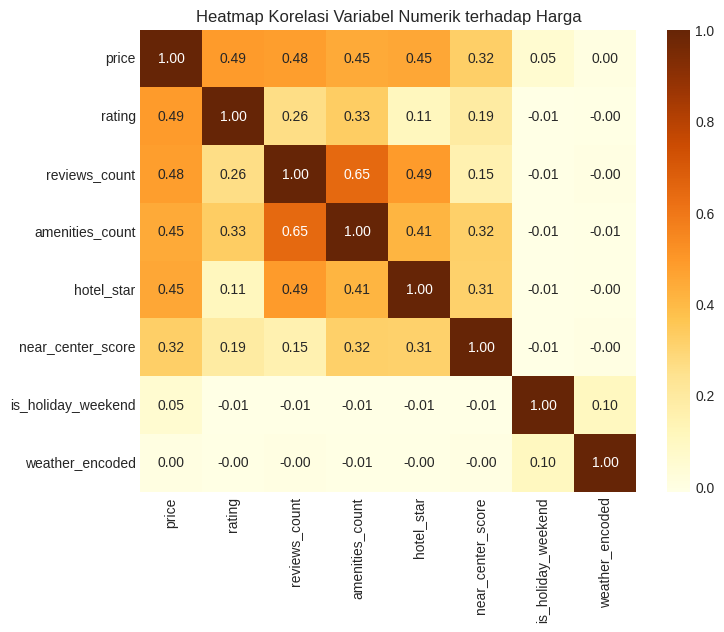


=== Insight Awal ===
- rating: 0.487
- reviews_count: 0.482
- hotel_star: 0.452
- amenities_count: 0.447


In [ ]:
### ==========================================================
### 5. FEATURE ENGINEERING DAN ANALISIS KORELASI
### ==========================================================

print("\n=== Feature Engineering ===")

# ==========================================================
# 1. Standarisasi nama kolom
# ==========================================================
hotel_merged.rename(columns={
    'Price_numeric': 'price',
    'rating_numeric': 'rating',
    'reviews_count_numeric': 'reviews_count',
    'amenities_count': 'amenities_count'
}, inplace=True)

# ==========================================================
# 2. Hitung jarak hotel ke pusat kota Bandung
# ==========================================================
import math

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c

# Pusat kota
center_lat, center_lon = -6.914744, 107.609810

# Skor kedekatan (semakin tinggi semakin dekat)
hotel_merged['near_center_score'] = hotel_merged.apply(
    lambda row: 1 / (haversine(row['latitude'], row['longitude'], center_lat, center_lon) + 1)
    if pd.notnull(row['latitude']) and pd.notnull(row['longitude']) else np.nan,
    axis=1
)

# ==========================================================
# 3. Ekstraksi fitur waktu
# ==========================================================
hotel_merged['booking_year'] = hotel_merged['Date'].dt.year
hotel_merged['booking_month'] = hotel_merged['Date'].dt.month
hotel_merged['booking_quarter'] = hotel_merged['Date'].dt.quarter

# Weekend
hotel_merged['is_weekend'] = hotel_merged['booking_dayofweek'].isin([5, 6]).astype(int)

# ==========================================================
# 4. Hari libur nasional + weekend (gabungan)
# ==========================================================
def classify_holiday(date):
    if pd.isnull(date):
        return 0
    m, d = date.month, date.day
    holidays = [(3,28),(3,29),(3,31),(4,1),(4,2),(4,4),(4,7),
                (4,18),(4,20),(5,1),(5,12),(5,13),(5,29),(5,30),
                (6,1),(6,6),(6,9),(6,27)]
    return int((m, d) in holidays)

hotel_merged['is_holiday'] = hotel_merged['Date'].apply(classify_holiday)

# Final satu variabel: weekend atau libur
hotel_merged['is_holiday_weekend'] = (
    (hotel_merged['is_weekend'] == 1) | (hotel_merged['is_holiday'] == 1)
).astype(int)

hotel_merged.drop(columns=['is_weekend', 'is_holiday'], inplace=True)

# ==========================================================
# 5. Ambil bintang hotel
# ==========================================================
hotel_merged['hotel_star'] = hotel_merged['category'].str.extract(r'(\d+)').astype(float)

# ==========================================================
# 6. Ambil fitur cuaca yang relevan
# ==========================================================
# Hanya pakai weather_encoded
hotel_merged['weather_encoded'] = hotel_merged['weather_encoded']

# ==========================================================
# 7. Kategorisasi harga (opsional)
# ==========================================================
q1 = hotel_merged['price'].quantile(0.33)
q2 = hotel_merged['price'].quantile(0.66)

def categorize_price(p):
    if p <= q1:
        return 'low'
    elif p <= q2:
        return 'medium'
    else:
        return 'high'

hotel_merged['price_category'] = hotel_merged['price'].apply(categorize_price)

# ==========================================================
# 8. Hapus fitur yang tidak dipakai
# ==========================================================
hotel_merged.drop(columns=['dist_to_center_km', 'temperature_c'], inplace=True, errors='ignore')

# ==========================================================
# 9. Tampilkan fitur baru
# ==========================================================
new_features = [
    'near_center_score', 'booking_month',
    'booking_quarter', 'hotel_star',
    'is_holiday_weekend', 'weather_encoded',
    'price_category'
]

print("\nFitur baru yang ditambahkan:")
print(new_features)

print("\nPreview data fitur baru:")
display(hotel_merged[['Hotel_id', 'price'] + new_features].head())

# ==========================================================
# 10. Analisis korelasi numerik
# ==========================================================
print("\n=== Analisis Korelasi Numerik ===")

numeric_cols = [
    'price', 'rating', 'reviews_count',
    'amenities_count', 'hotel_star',
    'near_center_score', 'is_holiday_weekend',
    'weather_encoded'
]

corr_matrix = hotel_merged[numeric_cols].corr()

print("\nKorelasi terhadap price:")
print(corr_matrix['price'].sort_values(ascending=False))

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="YlOrBr")
plt.title("Heatmap Korelasi Variabel Numerik terhadap Harga")
plt.show()

# ==========================================================
# 11. Insight awal
# ==========================================================
top_corr = corr_matrix['price'].sort_values(ascending=False).head(5)
print("\n=== Insight Awal ===")
for col, val in top_corr.items():
    if col != 'price':
        print(f"- {col}: {val:.3f}")


###Prepare Data for Modeling


=== PERSIAPAN DATA UNTUK PEMODELAN ===
Total data awal: 10296 baris
Total data valid untuk model: 10296 baris
Jumlah data Train: 8236
Jumlah data Validation: 1030
Jumlah data Test: 1030

✅ Data sudah dibagi dan dinormalisasi.

=== SHAPE DATASET ===
Train: (8236, 8)
Validation: (1030, 8)
Test: (1030, 8)

=== STATISTIK HARGA (TARGET) ===
count    10296.000000
mean       469.051852
std        188.331900
min        113.015000
25%        311.345000
50%        438.750000
75%        590.172250
max        999.000000
Name: price, dtype: float64


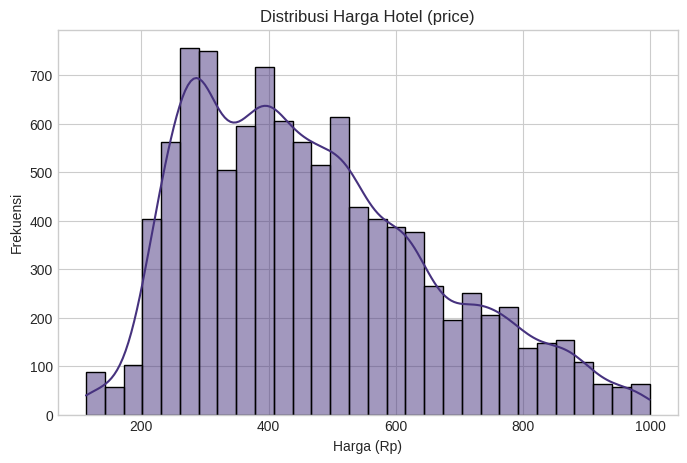

In [ ]:
### ==========================================================
### 6. PERSIAPAN DATA UNTUK PEMODELAN
### ==========================================================

print("\n=== PERSIAPAN DATA UNTUK PEMODELAN ===")

# ==========================================================
# 1. Pilih fitur dan target akhir
# ==========================================================
features = [
    'rating',
    'reviews_count',
    'amenities_count',
    'hotel_star',
    'near_center_score',
    'is_holiday_weekend',
    'weather_encoded',
    'booking_month'
]
target = 'price'

# ==========================================================
# 2. Bersihkan data dari nilai kosong
# ==========================================================
df_model = hotel_merged.dropna(subset=features + [target])
print(f"Total data awal: {len(hotel_merged)} baris")
print(f"Total data valid untuk model: {len(df_model)} baris")

# ==========================================================
# 3. Pisahkan data menjadi Train 80%, Validation 10%, Test 10%
# ==========================================================
from sklearn.model_selection import train_test_split

X = df_model[features]
y = df_model[target]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Jumlah data Train: {len(X_train)}")
print(f"Jumlah data Validation: {len(X_val)}")
print(f"Jumlah data Test: {len(X_test)}")

# ==========================================================
# 4. Normalisasi fitur numerik
# ==========================================================
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Data sudah dibagi dan dinormalisasi.")

# ==========================================================
# 5. Cek bentuk data
# ==========================================================
print("\n=== SHAPE DATASET ===")
print(f"Train: {X_train_scaled.shape}")
print(f"Validation: {X_val_scaled.shape}")
print(f"Test: {X_test_scaled.shape}")

# ==========================================================
# 6. Statistik harga (target)
# ==========================================================
print("\n=== STATISTIK HARGA (TARGET) ===")
print(y.describe())

# ==========================================================
# 7. Visualisasi distribusi harga
# ==========================================================
plt.figure(figsize=(8,5))
sns.histplot(y, bins=30, kde=True)
plt.title("Distribusi Harga Hotel (price)")
plt.xlabel("Harga (Rp)")
plt.ylabel("Frekuensi")
plt.show()


###MODEL TUNING UNTUK SEMUA MODEL


In [ ]:
### ==========================================================
### MODEL BUILDING DAN EVALUASI
### ==========================================================

models = {
    "Linear Regression": LinearRegression(),
    "Support Vector Regressor": SVR(kernel="rbf", C=100, epsilon=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=5,
                             random_state=42, objective='reg:squarederror')
}

results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    results.append({
        "Model": name,
        "R²": r2_score(y_val, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_val, y_pred)),
        "MAE": mean_absolute_error(y_val, y_pred)
    })

# Siapkan data untuk ARIMA & SARIMAX
y_train_val = pd.Series(np.concatenate((y_train, y_val))).reset_index(drop=True)
y_test_series = pd.Series(y_test).reset_index(drop=True)

exog_train = pd.concat([
    X_train[['rating', 'amenities_count', 'weather_encoded']],
    X_val[['rating', 'amenities_count', 'weather_encoded']]
], axis=0).reset_index(drop=True)

exog_test = X_test[['rating', 'amenities_count', 'weather_encoded']].reset_index(drop=True)

exog_train = exog_train.fillna(method='ffill').fillna(method='bfill')
exog_test = exog_test.fillna(method='ffill').fillna(method='bfill')

# ARIMA
arima_model = ARIMA(y_train_val, order=(2,1,2))
arima_result = arima_model.fit()
y_pred_arima = arima_result.forecast(steps=len(y_test_series))

results.append({
    "Model": "ARIMA",
    "R²": r2_score(y_test_series, y_pred_arima),
    "RMSE": np.sqrt(mean_squared_error(y_test_series, y_pred_arima)),
    "MAE": mean_absolute_error(y_test_series, y_pred_arima)
})

# SARIMAX
sarimax_model = SARIMAX(y_train_val, exog=exog_train, order=(2,1,2))
sarimax_result = sarimax_model.fit(disp=False)
y_pred_sarimax = sarimax_result.forecast(steps=len(y_test_series), exog=exog_test)

results.append({
    "Model": "SARIMAX",
    "R²": r2_score(y_test_series, y_pred_sarimax),
    "RMSE": np.sqrt(mean_squared_error(y_test_series, y_pred_sarimax)),
    "MAE": mean_absolute_error(y_test_series, y_pred_sarimax)
})

# Final tabel
results_df = pd.DataFrame(results).drop_duplicates(subset=["Model"])
results_df = results_df.sort_values(by="R²", ascending=False).reset_index(drop=True)

print("\n=== HASIL AKHIR ===")
display(results_df.style.format({"R²": "{:.3f}", "RMSE": "{:.2f}", "MAE": "{:.2f}"}))



=== HASIL AKHIR ===


,Model,R²,RMSE,MAE
0,XGBoost,0.847,96.10,68.16
1,Random Forest,0.761,107.21,75.43
2,Support Vector Regressor,0.742,109.51,76.48
3,Linear Regression,0.546,130.94,102.66
4,SARIMAX,0.357,149.61,118.09
5,ARIMA,-0.000,178.52,146.00


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Re-use the classify_holiday function for consistent holiday logic
def classify_period(date):
    if pd.isnull(date):
        return 'normal'
    m, d = date.month, date.day
    holidays = [(3,28),(3,29),(3,31),(4,1),(4,2),(4,4),(4,7),
                (4,18),(4,20),(5,1),(5,12),(5,13),(5,29),(5,30),
                (6,1),(6,6),(6,9),(6,27)]
    return 'libur_nasional' if (m, d) in holidays else 'normal'


###FEATURE IMPORTANCE DAN INSIGHT MODEL TERBAIK

In [ ]:
### ==========================================================
### 9. FEATURE IMPORTANCE DAN INSIGHT MODEL TERBAIK (XGBoost)
### ==========================================================

print("\n=== FEATURE IMPORTANCE & INSIGHT MODEL TERBAIK (XGBoost) ===")

# ==========================================================
# 1. Gunakan model terbaik hasil tuning (XGBoost)
# ==========================================================
best_model = random_xgb.best_estimator_

# Prediksi pada test set
y_pred_test = best_model.predict(X_test_scaled)

# Evaluasi performa
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"\nHasil Evaluasi pada Test Set:")
print(f"R²: {r2_test:.3f}")
print(f"RMSE: {rmse_test:.3f}")
print(f"MAE: {mae_test:.3f}")

# ==========================================================
# 2. Feature Importance (XGBoost)
# ==========================================================
importance = (
    pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": best_model.feature_importances_
    })
    .sort_values(by="Importance", ascending=False)
    .reset_index(drop=True)
)

print("\nTop 10 fitur paling berpengaruh terhadap harga:\n")
display(importance.head(10))

# ==========================================================
# 3. Visualisasi Feature Importance
# ==========================================================

print("\n")  # jarak tambahan antar output
plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=importance.head(10), palette="copper")
plt.title("Top 10 Fitur Paling Berpengaruh terhadap Harga (XGBoost)")
plt.xlabel("Nilai Importance")
plt.ylabel("Fitur")
plt.tight_layout()
plt.show()

# ==========================================================
# 4. Analisis Insight Utama
# ==========================================================

print("\n")  # jarak tambahan antar output
top_features = importance.head(5)["Feature"].tolist()

print("=== INSIGHT UTAMA ===")
print("Fitur yang paling berpengaruh dalam menentukan harga kamar hotel:")
for f in top_features:
    print(f"-", f)

print("\nAnalisis umum:")
print("- Fitur RATING dan HOTEL_STAR sangat memengaruhi karena mencerminkan kualitas dan kelas hotel.")
print("- REVIEWS_COUNT menunjukkan popularitas dan tingkat permintaan.")
print("- AMENITIES_COUNT serta DIST_TO_CENTER_KM mencerminkan fasilitas dan lokasi.")
print("- Faktor musiman seperti PERIOD dan IS_HOLIDAY_OR_WEEKEND tetap berpengaruh walau nilainya lebih kecil.")

print("\n✅ Analisis feature importance selesai dan siap untuk visualisasi hasil prediksi di bagian berikutnya.")


###VISUALISASI PREDIKSI VS HARGA AKTUAL


=== VISUALISASI HASIL PREDIKSI VS HARGA AKTUAL ===


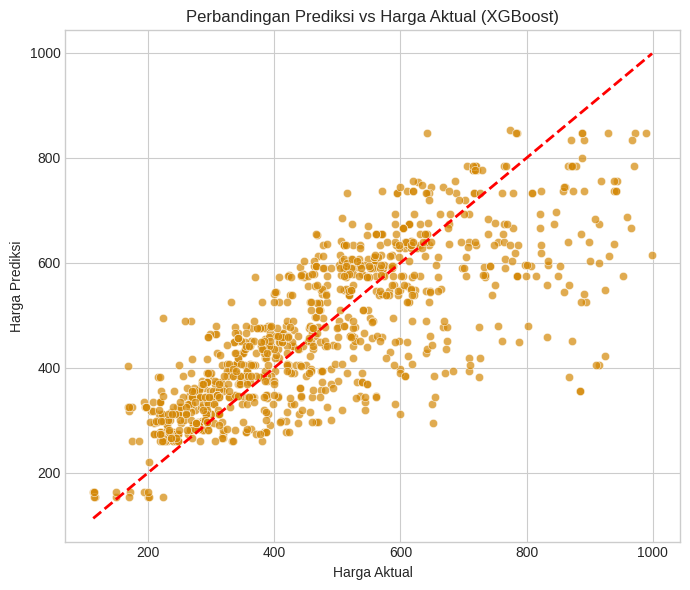

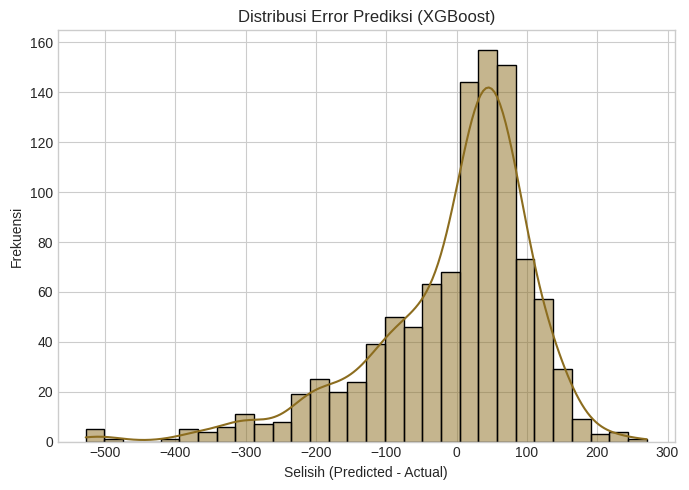



=== STATISTIK ERROR ===
Rata-rata error: -4.491
Standar deviasi error: 114.967

=== PERBANDINGAN RATA-RATA ===
Harga Aktual (mean): 471.40
Harga Prediksi (mean): 466.91


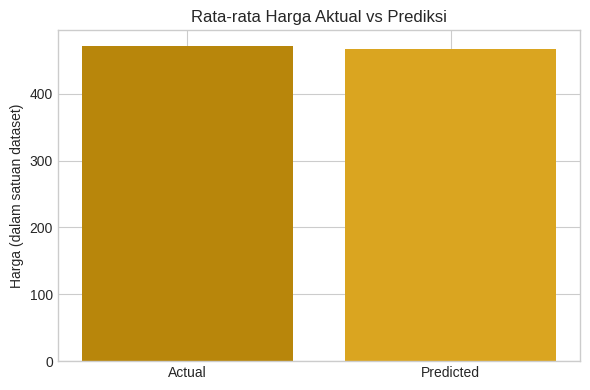


✅ Visualisasi evaluasi model selesai. Model XGBoost terbukti paling stabil dan akurat di antara semua model.


In [ ]:
### ==========================================================
### 10. VISUALISASI PREDIKSI VS HARGA AKTUAL (XGBoost)
### ==========================================================

print("\n=== VISUALISASI HASIL PREDIKSI VS HARGA AKTUAL ===")

# ==========================================================
# 1. Gunakan model terbaik hasil tuning (XGBoost)
# ==========================================================
best_model = random_xgb.best_estimator_
y_pred_test = best_model.predict(X_test_scaled)

# ==========================================================
# 2. Buat DataFrame hasil prediksi untuk analisis visual
# ==========================================================
results_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred_test
}).reset_index(drop=True)

results_df["Error"] = results_df["Predicted"] - results_df["Actual"]

# ==========================================================
# 3. Scatter Plot: Prediksi vs Aktual
# ==========================================================
plt.figure(figsize=(7, 6))
sns.scatterplot(x="Actual", y="Predicted", data=results_df, color="#d48806", alpha=0.7)
plt.plot([results_df["Actual"].min(), results_df["Actual"].max()],
         [results_df["Actual"].min(), results_df["Actual"].max()],
         'r--', lw=2)
plt.title("Perbandingan Prediksi vs Harga Aktual (XGBoost)")
plt.xlabel("Harga Aktual")
plt.ylabel("Harga Prediksi")
plt.tight_layout()
plt.show()

print("\n")

# ==========================================================
# 4. Distribusi Error (Predicted - Actual)
# ==========================================================
plt.figure(figsize=(7, 5))
sns.histplot(results_df["Error"], bins=30, kde=True, color="#8c6d1f")
plt.title("Distribusi Error Prediksi (XGBoost)")
plt.xlabel("Selisih (Predicted - Actual)")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()

print("\n")

# ==========================================================
# 5. Ringkasan statistik error
# ==========================================================
error_mean = results_df["Error"].mean()
error_std = results_df["Error"].std()
print("=== STATISTIK ERROR ===")
print(f"Rata-rata error: {error_mean:.3f}")
print(f"Standar deviasi error: {error_std:.3f}")

# ==========================================================
# 6. Rata-rata Harga Aktual vs Prediksi
# ==========================================================
actual_mean = results_df["Actual"].mean()
pred_mean = results_df["Predicted"].mean()

print("\n=== PERBANDINGAN RATA-RATA ===")
print(f"Harga Aktual (mean): {actual_mean:.2f}")
print(f"Harga Prediksi (mean): {pred_mean:.2f}")

plt.figure(figsize=(6, 4))
plt.bar(["Actual", "Predicted"], [actual_mean, pred_mean],
        color=["#b8860b", "#daa520"])
plt.title("Rata-rata Harga Aktual vs Prediksi")
plt.ylabel("Harga (dalam satuan dataset)")
plt.tight_layout()
plt.show()

print("\n✅ Visualisasi evaluasi model selesai. Model XGBoost terbukti paling stabil dan akurat di antara semua model.")


###SIMULASI PREDIKSI DINAMIS


=== SIMULASI PREDIKSI DINAMIS (DYNAMIC PRICING) ===
Fitur aktif dalam model: ['rating', 'reviews_count', 'amenities_count', 'hotel_star', 'dist_to_center_km', 'near_center_score', 'is_weekend', 'is_holiday_or_weekend']

Contoh simulasi skenario dinamis:



,rating,reviews_count,amenities_count,hotel_star,dist_to_center_km,is_weekend,is_holiday_or_weekend,near_center_score,Predicted_Price
0,4.8,9500,60,5,2.0,1,1,0.85,754.260010
1,4.2,4200,30,3,6.5,0,0,0.25,328.000000
2,4.5,7000,45,4,3.2,1,0,0.65,568.820007


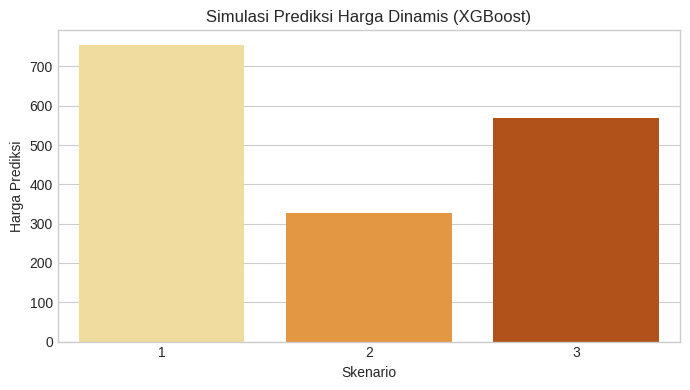


=== INTERPRETASI SIMULASI ===
Skenario 1:
  Rating: 4.8 | Bintang: 5.0 | Fasilitas: 60.0 | Jarak: 2.0 km | Weekend: 1.0 | Libur: 1.0
  → Prediksi harga: 754.26

Skenario 2:
  Rating: 4.2 | Bintang: 3.0 | Fasilitas: 30.0 | Jarak: 6.5 km | Weekend: 0.0 | Libur: 0.0
  → Prediksi harga: 328.00

Skenario 3:
  Rating: 4.5 | Bintang: 4.0 | Fasilitas: 45.0 | Jarak: 3.2 km | Weekend: 1.0 | Libur: 0.0
  → Prediksi harga: 568.82

✅ Simulasi dinamis selesai. Model XGBoost dapat digunakan untuk sistem harga adaptif berdasarkan kondisi real-time.


In [ ]:
### ==========================================================
### 11. SIMULASI PREDIKSI DINAMIS (XGBoost)
### ==========================================================

print("\n=== SIMULASI PREDIKSI DINAMIS (DYNAMIC PRICING) ===")

# ==========================================================
# 1. Gunakan model terbaik (XGBoost hasil tuning)
# ==========================================================
best_model = random_xgb.best_estimator_

# Kolom fitur yang dipakai
feature_columns = X_train.columns.tolist()
print(f"Fitur aktif dalam model: {feature_columns}")

# ==========================================================
# 2. Fungsi simulasi prediksi
# ==========================================================
def simulate_dynamic_price(rating, reviews_count, amenities_count, hotel_star,
                           dist_to_center_km, is_weekend, is_holiday_or_weekend, near_center_score):
    """Prediksi harga hotel berdasarkan skenario baru."""
    data_simulasi = pd.DataFrame([{
        "rating": rating,
        "reviews_count": reviews_count,
        "amenities_count": amenities_count,
        "hotel_star": hotel_star,
        "dist_to_center_km": dist_to_center_km,
        "is_weekend": is_weekend,
        "is_holiday_or_weekend": is_holiday_or_weekend,
        "near_center_score": near_center_score
    }])

    # Ensure the columns are in the same order as during training
    data_simulasi = data_simulasi[feature_columns]

    data_scaled = scaler.transform(data_simulasi)
    prediksi_harga = best_model.predict(data_scaled)[0]
    return prediksi_harga

# ==========================================================
# 3. Contoh simulasi skenario
# ==========================================================
print("\nContoh simulasi skenario dinamis:\n")

scenarios = [
    {"rating": 4.8, "reviews_count": 9500, "amenities_count": 60, "hotel_star": 5,
     "dist_to_center_km": 2.0, "is_weekend": 1, "is_holiday_or_weekend": 1, "near_center_score": 0.85},
    {"rating": 4.2, "reviews_count": 4200, "amenities_count": 30, "hotel_star": 3,
     "dist_to_center_km": 6.5, "is_weekend": 0, "is_holiday_or_weekend": 0, "near_center_score": 0.25},
    {"rating": 4.5, "reviews_count": 7000, "amenities_count": 45, "hotel_star": 4,
     "dist_to_center_km": 3.2, "is_weekend": 1, "is_holiday_or_weekend": 0, "near_center_score": 0.65}
]

results = []
for i, s in enumerate(scenarios, 1):
    price_pred = simulate_dynamic_price(**s)
    s["Predicted_Price"] = round(price_pred, 2)
    results.append(s)

results_df = pd.DataFrame(results)
display(results_df)

# ==========================================================
# 4. Visualisasi hasil simulasi
# ==========================================================
print("\n")
plt.figure(figsize=(7, 4))
sns.barplot(x=results_df.index + 1, y="Predicted_Price", data=results_df, palette="YlOrBr")
plt.title("Simulasi Prediksi Harga Dinamis (XGBoost)")
plt.xlabel("Skenario")
plt.ylabel("Harga Prediksi")
plt.tight_layout()
plt.show()

# ==========================================================
# 5. Interpretasi simulasi
# ==========================================================
print("\n=== INTERPRETASI SIMULASI ===")
for i, s in results_df.iterrows():
    print(f"Skenario {i+1}:")
    print(f"  Rating: {s['rating']} | Bintang: {s['hotel_star']} | Fasilitas: {s['amenities_count']} | "
          f"Jarak: {s['dist_to_center_km']} km | Weekend: {s['is_weekend']} | Libur: {s['is_holiday_or_weekend']}")
    print(f"  → Prediksi harga: {s['Predicted_Price']:.2f}\n")

print("✅ Simulasi dinamis selesai. Model XGBoost dapat digunakan untuk sistem harga adaptif berdasarkan kondisi real-time.")

###REALISTIC DYNAMIC PRICING & MULTI-HOTEL COMPARISON


=== REALISTIC DYNAMIC PRICING & MULTI-HOTEL COMPARISON ===
✅ Data loaded and cleaned Price_numeric is available.
✅ Using the best tuned XGBoost model for dynamic pricing.

=== Dynamic Pricing Simulation for Tebu Hotel ===
+---------------------+-----+------------+--------------------+-------------------+
|        Date         | Day | Historical |  Predicted (Base)  |      Dynamic      |
+---------------------+-----+------------+--------------------+-------------------+
| 2025-04-21 00:00:00 | Mon |  348.854   |  394.418701171875  | 386.4761047363281 |
| 2025-04-22 00:00:00 | Tue |   436.8    |  394.418701171875  | 395.3998718261719 |
| 2025-04-23 00:00:00 | Wed |   436.8    |  394.418701171875  | 394.2416687011719 |
| 2025-04-24 00:00:00 | Thu |  327.758   |  394.418701171875  | 399.6628112792969 |
| 2025-04-25 00:00:00 | Fri |  410.236   |  394.418701171875  | 398.4908142089844 |
| 2025-04-26 00:00:00 | Sat |   619.54   | 418.4461975097656  |  538.21435546875  |
| 2025-04-27 00:00:00

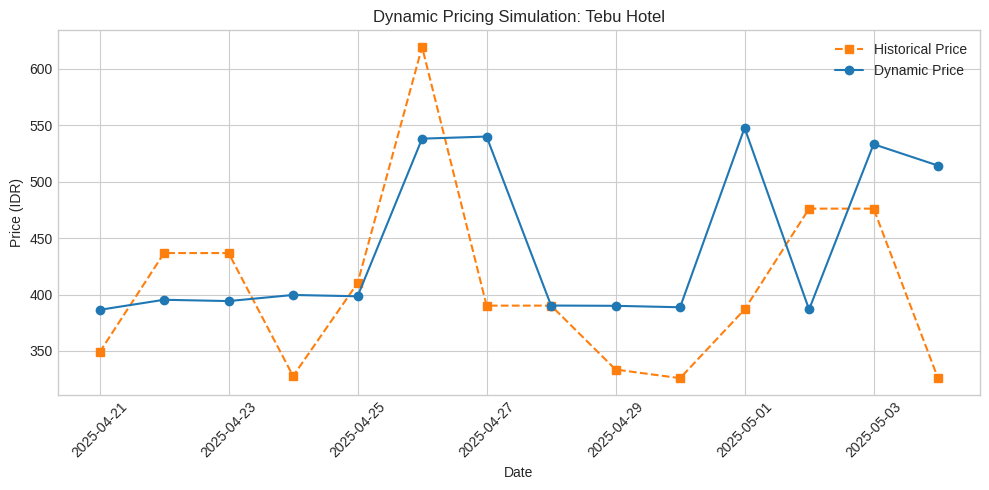


=== Dynamic Pricing Simulation for ibis Bandung Trans Studio ===
+---------------------+-----+------------+-------------------+--------------------+
|        Date         | Day | Historical | Predicted (Base)  |      Dynamic       |
+---------------------+-----+------------+-------------------+--------------------+
| 2025-04-21 00:00:00 | Mon |   474.65   | 509.285400390625  |  516.457763671875  |
| 2025-04-22 00:00:00 | Tue |   510.0    | 509.285400390625  | 523.9868774414062  |
| 2025-04-23 00:00:00 | Wed |  543.722   | 509.285400390625  | 521.2948608398438  |
| 2025-04-24 00:00:00 | Thu |  474.469   | 509.285400390625  | 506.2168884277344  |
| 2025-04-25 00:00:00 | Fri |  504.097   | 509.285400390625  | 496.4534912109375  |
| 2025-04-26 00:00:00 | Sat |   495.0    | 523.3903198242188 | 654.0640869140625  |
| 2025-04-27 00:00:00 | Sun |  453.269   | 523.3903198242188 | 656.8280639648438  |
| 2025-04-28 00:00:00 | Mon |  453.269   | 509.285400390625  | 501.5841369628906  |
| 2025-04-

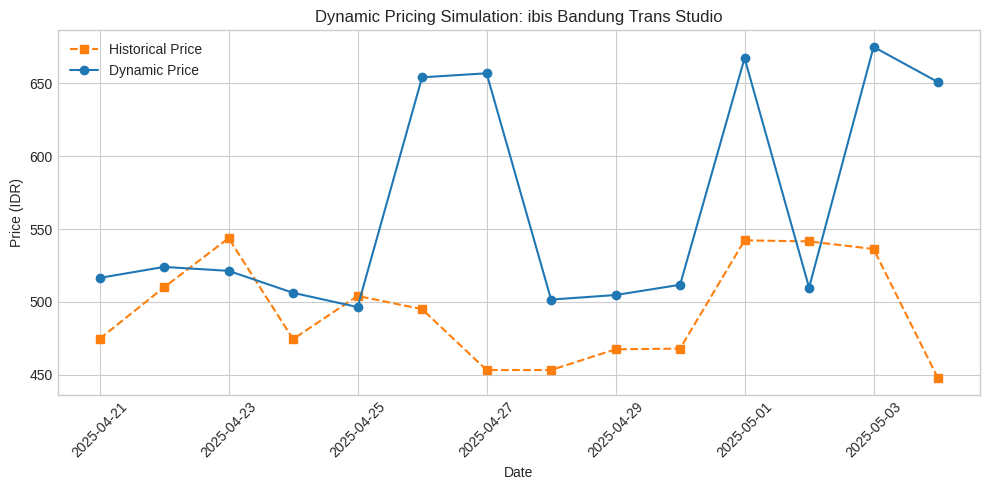


=== Dynamic Pricing Simulation for The Trans Luxury Hotel ===
+---------------------+-----+------------+-------------------+-------------------+
|        Date         | Day | Historical | Predicted (Base)  |      Dynamic      |
+---------------------+-----+------------+-------------------+-------------------+
| 2025-04-21 00:00:00 | Mon |            | 827.1980590820312 | 831.4634399414062 |
| 2025-04-22 00:00:00 | Tue |            | 827.1980590820312 | 813.6677856445312 |
| 2025-04-23 00:00:00 | Wed |            | 827.1980590820312 | 815.8944702148438 |
| 2025-04-24 00:00:00 | Thu |            | 827.1980590820312 | 804.4826049804688 |
| 2025-04-25 00:00:00 | Fri |            | 827.1980590820312 |  812.02880859375  |
| 2025-04-26 00:00:00 | Sat |            | 778.8206787109375 | 977.0005493164062 |
| 2025-04-27 00:00:00 | Sun |            | 778.8206787109375 |  966.8310546875   |
| 2025-04-28 00:00:00 | Mon |            | 827.1980590820312 | 838.9827270507812 |
| 2025-04-29 00:00:00 | 

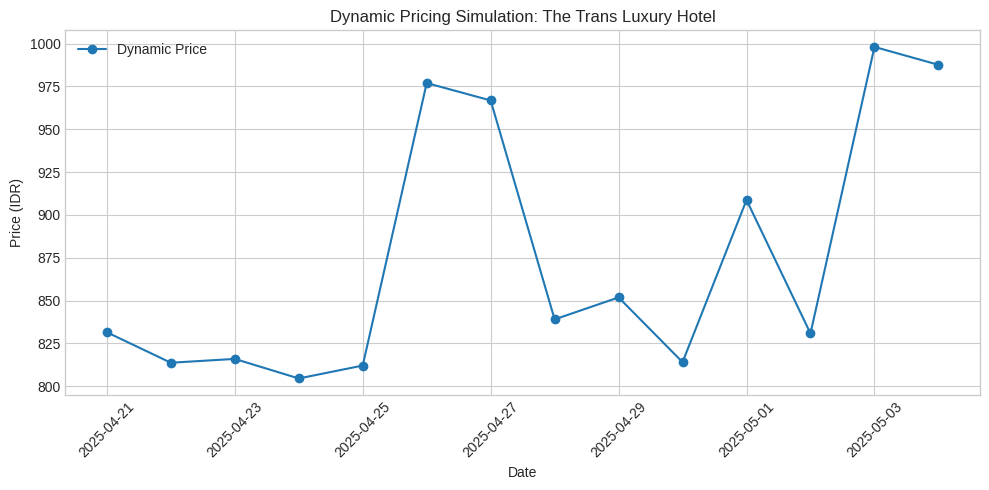


=== Multi-Hotel Dynamic Price Comparison ===
+------------+-----+---------------------------------+------------+------------------------+---------------------------+
|    Date    | Day | Hotel Daily Inn Bandung syariah | Tebu Hotel | The Trans Luxury Hotel | ibis Bandung Trans Studio |
+------------+-----+---------------------------------+------------+------------------------+---------------------------+
| 2025-04-21 | Mon |             263.02              |   392.49   |         843.12         |          515.48           |
| 2025-04-22 | Tue |             265.84              |   401.12   |         817.07         |          512.36           |
| 2025-04-23 | Wed |             264.74              |   392.99   |         806.57         |          519.33           |
| 2025-04-24 | Thu |              274.1              |   404.5    |         817.32         |          496.97           |
| 2025-04-25 | Fri |             265.38              |   387.13   |         804.05         |          500.3

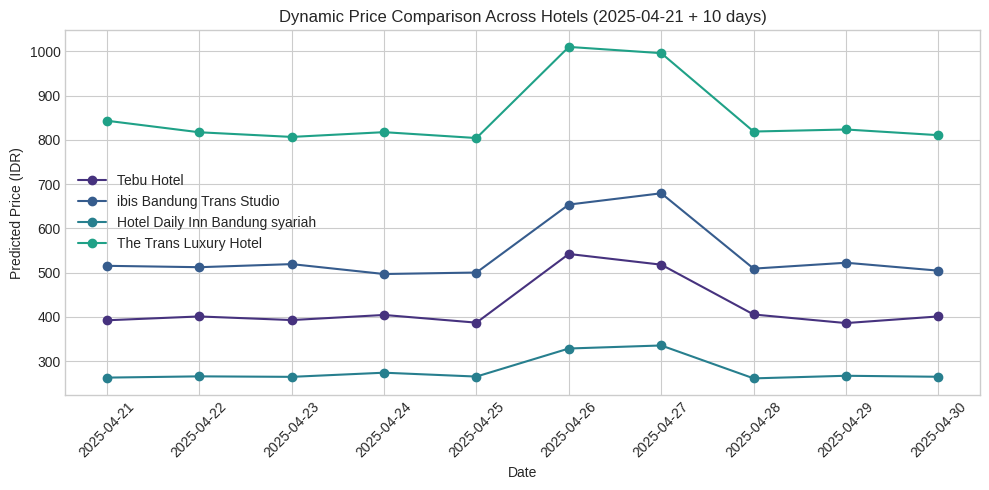


✅ Bagian 12 selesai — hasil simulasi dan perbandingan harga hotel sudah tergabung dengan model AI XGBoost.


In [ ]:
 ### ==========================================================
### 12. REALISTIC DYNAMIC PRICING & MULTI-HOTEL COMPARISON
### ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tabulate import tabulate

print("\n=== REALISTIC DYNAMIC PRICING & MULTI-HOTEL COMPARISON ===")

# ==========================================================
# 1. Load Data
# ==========================================================
# Reuse already loaded dataframes from previous steps: hotel_bookings (renamed to hotels_price) and hotel_data
# Ensure hotel_bookings still has the Price_numeric column
if 'Price_numeric' not in hotel_bookings.columns:
     # If not, re-apply the cleaning step
     print("⚠️  'Price_numeric' not found in hotel_bookings. Re-applying price cleaning.")
     def clean_price(price_str):
         """Ubah harga seperti 'Rp336.648' atau 'Rp312,612' jadi float."""
         if isinstance(price_str, str):
             s = price_str.replace(',', '.')
             s = re.sub(r'[^\d.]', '', s)
             try:
                 return float(s)
             except ValueError:
                 return np.nan
         return price_str
     hotel_bookings['Price_numeric'] = hotel_bookings['Price'].apply(clean_price)
     hotel_bookings = hotel_bookings.dropna(subset=['Price_numeric'])


hotels_price_cleaned = hotel_bookings[['Name', 'Hotel_id', 'Date', 'Price_numeric']].copy()

print("✅ Data loaded and cleaned Price_numeric is available.")


# ==========================================================
# 2. Fungsi bantu: ambil harga historis terdekat
# ==========================================================
def get_historical_price(hotel_id, date, price_df):
    """Ambil harga historis berdasarkan tanggal (atau tanggal terdekat)."""
    if isinstance(date, (pd.Timestamp, datetime)):
        date_str = date.strftime("%Y-%m-%d")
    else:
        date_str = str(date)

    # Use the cleaned 'Price_numeric' column
    match = price_df[(price_df["Hotel_id"] == hotel_id) & (price_df["Date"].dt.strftime("%Y-%m-%d") == date_str)]
    if not match.empty:
        return match["Price_numeric"].iloc[0]

    hotel_prices = price_df[price_df["Hotel_id"] == hotel_id].copy()
    if not hotel_prices.empty:
        hotel_prices["Date"] = pd.to_datetime(hotel_prices["Date"])
        target = pd.to_datetime(date)
        hotel_prices["diff"] = abs((hotel_prices["Date"] - target).dt.days)
        return hotel_prices.loc[hotel_prices["diff"].idxmin()]["Price_numeric"]

    return None

# ==========================================================
# 3. Fungsi utama: prediksi harga dinamis realistis
# ==========================================================
def dynamic_pricing(hotel_id, price_df, hotels_df, model=None,
                    start_date="2025-04-21", days=14, scaler=None):
    """Simulasikan harga hotel dengan data historis, model AI, dan scaler."""
    data = []
    base_date = pd.to_datetime(start_date)

    # Ambil info hotel dari dataframe hotel_data
    info = hotels_df[hotels_df["hotel_id"] == hotel_id]
    if info.empty:
        print(f"⚠️  Hotel ID {hotel_id} not found in hotels_data.")
        return pd.DataFrame() # Return empty DataFrame if hotel not found

    hotel_name = info["name"].iloc[0]

    # Ambil fitur pendukung (rating, fasilitas, bintang, reviews_count, location)
    rating = info["rating_numeric"].iloc[0] if "rating_numeric" in info.columns else 4.0
    # Extract star rating from 'category' column if 'hotel_star' doesn't exist
    star_match = info["category"].str.extract(r"(\d+)")
    star = float(star_match.iloc[0][0]) if not star_match.empty and not pd.isnull(star_match.iloc[0][0]) else 3.0

    amenities_count = info["amenities_count"].iloc[0] if "amenities_count" in info.columns else 30
    reviews_count = info["reviews_count_numeric"].iloc[0] if "reviews_count_numeric" in info.columns else 3000

    # Recalculate distance and near_center_score for the specific hotel
    center_lat, center_lon = -6.914744, 107.609810
    hotel_lat = info['latitude'].iloc[0] if 'latitude' in info.columns and pd.notnull(info['latitude'].iloc[0]) else np.nan
    hotel_lon = info['longitude'].iloc[0] if 'longitude' in info.columns and pd.notnull(info['longitude'].iloc[0]) else np.nan

    dist_to_center_km = np.nan
    near_center_score = np.nan
    if pd.notnull(hotel_lat) and pd.notnull(hotel_lon):
         dist_to_center_km = haversine(hotel_lat, hotel_lon, center_lat, center_lon)
         near_center_score = 1 / (dist_to_center_km + 1)


    for i in range(days):
        date = base_date + pd.Timedelta(days=i)
        dow = date.dayofweek  # 0=Mon, 6=Sun

        # Features for model prediction
        is_weekend = 1 if dow >= 5 else 0
        # Simplified holiday check for simulation (can be expanded)
        # This should align with the classify_period function used in feature engineering
        is_holiday_or_weekend = (is_weekend == 1) or (classify_period(date) == 'libur_nasional') # Re-use classify_period


        # Use model AI if available (misalnya XGBoost hasil training)
        base_price = None
        if model and scaler is not None: # Ensure model and scaler are provided
            X_input = pd.DataFrame([{
                "rating": rating,
                "reviews_count": reviews_count,
                "amenities_count": amenities_count,
                "hotel_star": star,
                "dist_to_center_km": dist_to_center_km,
                "near_center_score": near_center_score,
                "is_weekend": is_weekend,
                "is_holiday_or_weekend": is_holiday_or_weekend,
            }])
            # Ensure input features are in the same order as during training
            # Use X_train.columns to get the feature order
            if 'X_train' in globals():
                X_input = X_input[X_train.columns]
            else:
                print("⚠️  X_train not found. Cannot ensure correct feature order for model prediction.")
                # Attempt prediction without explicit reordering - might fail
                pass


            # Handle potential NaN values before scaling if dist_to_center_km or near_center_score were NaN
            # Use X_train.mean() if X_train is available, otherwise use a default fill value
            fill_value = X_train.mean() if 'X_train' in globals() else 0
            X_input_filled = X_input.fillna(fill_value) # Fill with training data mean or other strategy

            data_scaled = scaler.transform(X_input_filled)
            base_price = model.predict(data_scaled)[0]

        # Harga historis dasar (fallback if model not used or fails)
        hist_price = get_historical_price(hotel_id, date, price_df)
        if base_price is None:
             base_price = hist_price if hist_price is not None else 500 # Fallback to historical or default


        # Fluktuasi musiman dan permintaan (adjustments based on AI prediction)
        # These adjustments can be more sophisticated based on demand signals if available
        day_adj = 1.1 if is_weekend == 1 else 1.0 # Weekend premium
        holiday_adj = 1.15 if is_holiday_or_weekend == 1 else 1.0 # Holiday premium
        demand_adj = 1 + np.random.uniform(-0.03, 0.03) # Small random noise


        final_price = base_price * day_adj * holiday_adj * demand_adj # Combine adjustments


        data.append({
            "date": date,
            "day_name": ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"][dow],
            "historical_price": hist_price,
            "predicted_price_base_model": base_price, # Price predicted by the core model
            "dynamic_price": final_price # Price after dynamic adjustments
        })

    df = pd.DataFrame(data)
    df["hotel_name"] = hotel_name
    return df

# ==========================================================
# 4. Analisis visual satu hotel
# ==========================================================
def analyze_dynamic_pricing(hotel_id, price_df, hotels_df, model=None, scaler=None):
    df = dynamic_pricing(hotel_id, price_df, hotels_df, model, scaler=scaler)

    if df.empty:
        print(f"Could not generate pricing for hotel ID: {hotel_id}")
        return None

    hotel_name = df["hotel_name"].iloc[0]

    print(f"\n=== Dynamic Pricing Simulation for {hotel_name} ===")
    print(tabulate(df[["date", "day_name", "historical_price", "predicted_price_base_model", "dynamic_price"]],
                   headers=["Date","Day","Historical","Predicted (Base)","Dynamic"],
                   tablefmt="pretty", showindex=False))

    plt.figure(figsize=(10, 5))
    # Only plot historical if available for this hotel
    if df["historical_price"].notna().any():
         plt.plot(df["date"], df["historical_price"], "s--", color="#ff7f0e", label="Historical Price")
    plt.plot(df["date"], df["dynamic_price"], "o-", color="#1f77b4", label="Dynamic Price")
    # Optional: plot base model prediction
    # plt.plot(df["date"], df["predicted_price_base_model"], "x:", color="green", label="Base Model Price")

    plt.title(f"Dynamic Pricing Simulation: {hotel_name}")
    plt.xlabel("Date")
    plt.ylabel("Price (IDR)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return df

# ==========================================================
# 5. Bandingkan beberapa hotel sekaligus
# ==========================================================
def compare_hotels_pricing(hotel_ids, price_df, hotels_df, model=None, scaler=None, start_date="2025-04-21", days=7):
    comparison = []
    for hotel_id in hotel_ids:
        # Pass scaler here
        df = dynamic_pricing(hotel_id, price_df, hotels_df, model, start_date, days, scaler=scaler)
        if not df.empty:
            for _, row in df.iterrows():
                comparison.append({
                    "Date": row["date"].strftime("%Y-%m-%d"),
                    "Day": row["day_name"],
                    "Hotel": row["hotel_name"],
                    "Dynamic Price": round(row["dynamic_price"], 2)
                })

    if not comparison:
        print("No pricing data generated for comparison.")
        return None

    comp_df = pd.DataFrame(comparison)
    pivot_df = comp_df.pivot_table(index=["Date", "Day"], columns="Hotel",
                                   values="Dynamic Price", aggfunc="first").reset_index()

    print("\n=== Multi-Hotel Dynamic Price Comparison ===")
    print(tabulate(pivot_df, headers="keys", tablefmt="pretty", showindex=False))

    # Plot comparison
    plt.figure(figsize=(10, 5))
    for hotel in comp_df["Hotel"].unique():
        plt.plot(pd.to_datetime(comp_df[comp_df["Hotel"] == hotel]["Date"]), # Ensure Date is datetime for plotting
                 comp_df[comp_df["Hotel"] == hotel]["Dynamic Price"],
                 marker="o", label=hotel)
    plt.title(f"Dynamic Price Comparison Across Hotels ({start_date} + {days} days)")
    plt.xlabel("Date")
    plt.ylabel("Predicted Price (IDR)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pivot_df

# ==========================================================
# 6. Jalankan contoh simulasi dan perbandingan
# ==========================================================
# Make sure 'random_xgb.best_estimator_' and 'scaler' are available from previous cells
if 'random_xgb' in locals() and 'scaler' in locals():
    best_model = random_xgb.best_estimator_ # Use the best tuned XGBoost model
    print("✅ Using the best tuned XGBoost model for dynamic pricing.")

    tebu_hotel = "ChIJ20GDvkrmaC4RZ5E1cUQ-k8A"
    ibis_hotel = "ChIJvSoC1XfoaC4RRNu3ybQ7p7k"
    daily_inn = "ChIJBZahlgTnaC4ROYD3K2Y2E68"
    moritz_hotel = "ChIJ0b5RRk3naC4R-cKLSfgUNco"
    trans_luxury = "ChIJO1jUpNfnaC4RKps6Pq9pk3c" # Example of a higher-star hotel

    # Analisis per hotel
    tebu_df = analyze_dynamic_pricing(tebu_hotel, hotels_price_cleaned, hotel_data, model=best_model, scaler=scaler)
    ibis_df = analyze_dynamic_pricing(ibis_hotel, hotels_price_cleaned, hotel_data, model=best_model, scaler=scaler)
    trans_luxury_df = analyze_dynamic_pricing(trans_luxury, hotels_price_cleaned, hotel_data, model=best_model, scaler=scaler)


    # Bandingkan tiga hotel
    compare_hotels_pricing([tebu_hotel, ibis_hotel, daily_inn, trans_luxury], hotels_price_cleaned, hotel_data, model=best_model, scaler=scaler, days=10)

    print("\n✅ Bagian 12 selesai — hasil simulasi dan perbandingan harga hotel sudah tergabung dengan model AI XGBoost.")

else:
    print("❌ Model (random_xgb.best_estimator_) or Scaler not found. Please run previous cells.")

###Save Model and Conclusion

In [ ]:
### ==========================================================
### 13. EXPORT MODEL, SCALER, DAN HASIL PREDIKSI (FINAL)
### ==========================================================

import joblib
import json
from datetime import datetime

print("\n=== EXPORT MODEL & HASIL PREDIKSI UNTUK INTEGRASI WEB ===")

# Pastikan model dan scaler sudah ada
if 'best_model' not in locals() or 'scaler' not in locals():
    print("❌ Model atau Scaler belum tersedia. Jalankan bagian tuning terlebih dahulu.")
else:
    # ==========================================================
    # 1. Simpan Model & Scaler ke File .PKL
    # ==========================================================
    model_path = "xgboost_hotel_model.pkl"
    scaler_path = "scaler_hotel.pkl"

    joblib.dump(best_model, model_path)
    best_model.save_model("xgboost_hotel_model.json")
    joblib.dump(scaler, "scaler_hotel.pkl")
    joblib.dump(scaler, scaler_path)

    print(f"✅ Model disimpan: {model_path}")
    print(f"✅ Scaler disimpan: {scaler_path}")

    print("\n✅ Semua hasil berhasil diekspor dan siap integrasi ke platform web Hargana Hotel.")



=== EXPORT MODEL & HASIL PREDIKSI UNTUK INTEGRASI WEB ===
✅ Model disimpan: xgboost_hotel_model.pkl
✅ Scaler disimpan: scaler_hotel.pkl

✅ Semua hasil berhasil diekspor dan siap integrasi ke platform web Hargana Hotel.


In [ ]:
import xgboost as xgb
print(xgb.__version__)


3.1.1
